### Finetune the mobilenet on cifar-10 dataset

In [1]:
import tensorflow as tf
import time
import os
import numpy as np
from tensorflow.keras import layers, callbacks, models
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report
from datetime import datetime
import os

In [2]:
# === Settings ===
IMG_SIZE = 96
BATCH_SIZE = 64
EPOCHS = 20
USE_SUBSET = False
SUBSET_RATIO = 0.8
SAVE_DIR = "saved_models"

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [3]:
# === Load CIFAR-10 ===
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test # / 255.0
if USE_SUBSET:
    subset_size = int(len(x_train) * SUBSET_RATIO)
    x_train, y_train = x_train[:subset_size], y_train[:subset_size]

y_train = y_train.flatten()
y_test = y_test.flatten()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 label names
cifar10_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

def plot_sample_images(images, labels, class_names=cifar10_labels, n=16):
    """
    Plots a grid of sample images with labels.

    Args:
        images (np.ndarray): Array of images.
        labels (np.ndarray): Array of labels (flattened).
        class_names (list): List of class names.
        n (int): Number of images to show (default 16).
    """
    plt.figure(figsize=(10, 10))
    indices = np.random.choice(len(images), n, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i + 1)
        plt.imshow(images[idx])
        plt.title(class_names[labels[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

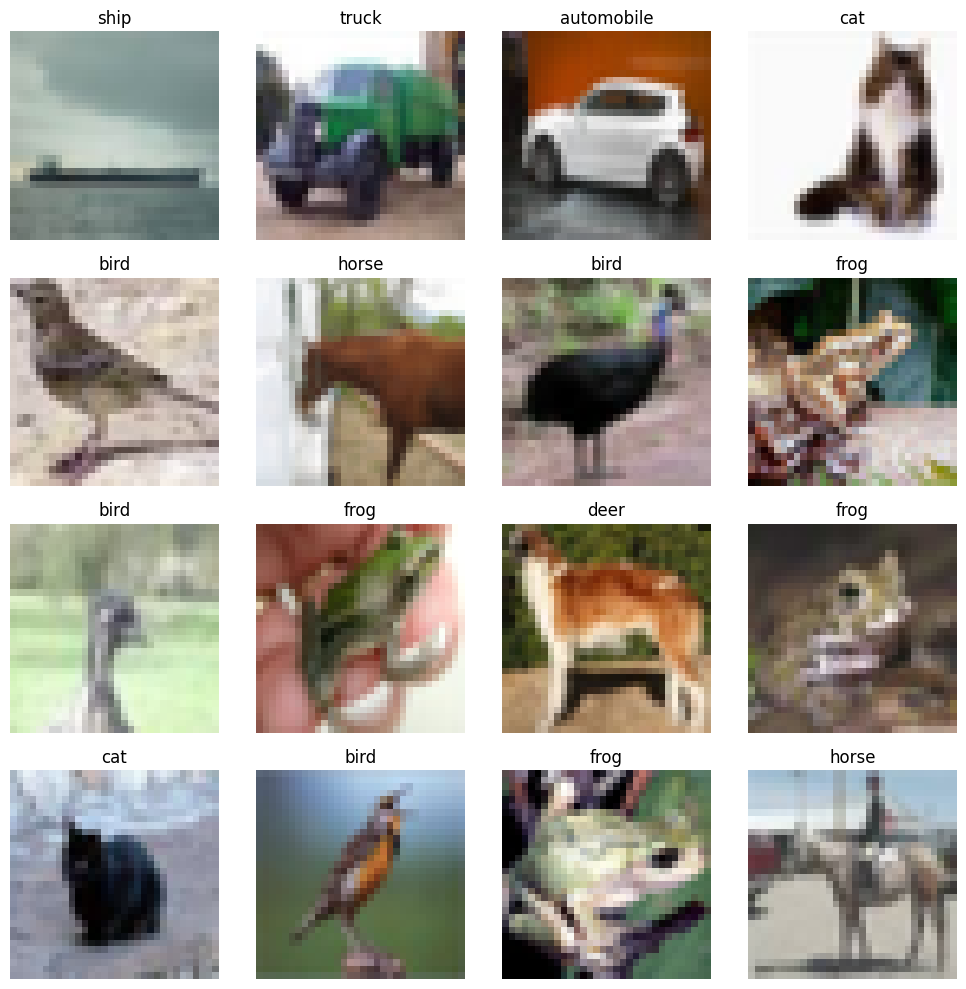

In [5]:
plot_sample_images(x_train, y_train, n=16)

In [6]:
# === Prepare tf.data datasets with on-the-fly resizing ===
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
from sklearn.model_selection import train_test_split

# Original training data: 50,000
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.3, random_state=42
)

# Create tf.data datasets
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
# === Now you can use train_ds and test_ds for model training ===
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

547
235
157


In [9]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers

In [10]:
# === Modify preprocess function to use MobileNetV2 preprocessing ===
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)  # MobileNetV2 preprocessing
    return image, label

In [11]:
# === Load Pretrained Base ===
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [12]:
len([layer for layer in base_model.layers if layer.trainable])

154

In [13]:
# === Freeze base for feature extraction (can unfreeze for fine-tuning later) ===
# Unfreeze all layers of the base model
base_model.trainable = True

# Freeze all layers except the last 1
for layer in base_model.layers[:-1]:
    layer.trainable = False

In [14]:
# Access the last layer of the base model
last_layer = base_model.layers[-1]
print(f"Last layer name: {last_layer.name}")
print(f"Last layer type: {type(last_layer)}")

# Get the output shape from the layer's output tensor
print(f"Last layer output shape: {last_layer.output.shape}")

Last layer name: out_relu
Last layer type: <class 'keras.src.layers.activations.relu.ReLU'>
Last layer output shape: (None, 3, 3, 1280)


In [15]:
# for layer in base_model.layers:
#     print(f"{layer.name}: {'Trainable' if layer.trainable else 'Frozen'}")

In [16]:
# === Add classification head instead of the last fully connection layer  ===
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='leaky_relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
])

In [17]:
# required callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Create callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(SAVE_DIR, 'mobilenet_model.h5'),    # best_weights
    monitor='val_loss',
    save_best_only=True
)

callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

In [18]:
# === Compile the model ===
from tensorflow.keras.optimizers import AdamW

# Use AdamW with weight decay
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# === Summary ===
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [19]:
import time

start_time = time.time()

# === Train the model ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

end_time = time.time()

Epoch 1/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4515 - loss: 1.6428

547/547 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.4517 - loss: 1.6420 - val_accuracy: 0.7363 - val_loss: 0.7648 - learning_rate: 1.0000e-04
Epoch 2/20
544/547 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7248 - loss: 0.7921

547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 26ms/step - accuracy: 0.7249 - loss: 0.7919 - val_accuracy: 0.7674 - val_loss: 0.6777 - learning_rate: 1.0000e-04
Epoch 3/20
544/547 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7600 - loss: 0.6928

547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.7600 - loss: 0.6927 - val_accuracy: 0.7755 - val_loss: 0.6440 - learning_rate: 1.0000e-04
Epoch 4/20
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7760 - loss: 0.6410

547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.7760 - loss: 0.6410 - val_accuracy: 0.7905 - val_loss: 0.6131 - learning_rate: 1.0000e-04
Epoch 5/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7911 - loss: 0.6045

547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7911 - loss: 0.6045 - val_accuracy: 0.7934 - val_loss: 0.5993 - learning_rate: 1.0000e-04
Epoch 6/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7989 - loss: 0.5777

547/547 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.7989 - loss: 0.5777 - val_accuracy: 0.7981 - val_loss: 0.5843 - learning_rate: 1.0000e-04
Epoch 7/20
544/547 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8056 - loss: 0.5573

547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8056 - loss: 0.5573 - val_accuracy: 0.7989 - val_loss: 0.5802 - learning_rate: 1.0000e-04
Epoch 8/20
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8151 - loss: 0.5356

547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8151 - loss: 0.5356 - val_accuracy: 0.8041 - val_loss: 0.5680 - learning_rate: 1.0000e-04
Epoch 9/20
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8175 - loss: 0.5195

547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8176 - loss: 0.5194 - val_accuracy: 0.8034 - val_loss: 0.5651 - learning_rate: 1.0000e-04
Epoch 10/20
544/547 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8258 - loss: 0.5037

547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8259 - loss: 0.5036 - val_accuracy: 0.8053 - val_loss: 0.5620 - learning_rate: 1.0000e-04
Epoch 11/20
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8283 - loss: 0.4842

547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.8283 - loss: 0.4842 - val_accuracy: 0.8069 - val_loss: 0.5580 - learning_rate: 1.0000e-04
Epoch 12/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8363 - loss: 0.4757

547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8363 - loss: 0.4757 - val_accuracy: 0.8085 - val_loss: 0.5549 - learning_rate: 1.0000e-04
Epoch 13/20
545/547 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8387 - loss: 0.4598

547/547 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8387 - loss: 0.4598 - val_accuracy: 0.8113 - val_loss: 0.5497 - learning_rate: 1.0000e-04
Epoch 14/20
544/547 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8440 - loss: 0.4495

547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.8441 - loss: 0.4495 - val_accuracy: 0.8097 - val_loss: 0.5490 - learning_rate: 1.0000e-04
Epoch 15/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8485 - loss: 0.4391

547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.8485 - loss: 0.4391 - val_accuracy: 0.8121 - val_loss: 0.5466 - learning_rate: 1.0000e-04
Epoch 16/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.8505 - loss: 0.4313 - val_accuracy: 0.8114 - val_loss: 0.5492 - learning_rate: 1.0000e-04
Epoch 17/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8530 - loss: 0.4245

547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8530 - loss: 0.4245 - val_accuracy: 0.8126 - val_loss: 0.5458 - learning_rate: 1.0000e-04
Epoch 18/20
544/547 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8587 - loss: 0.4089

547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8587 - loss: 0.4089 - val_accuracy: 0.8140 - val_loss: 0.5449 - learning_rate: 1.0000e-04
Epoch 19/20
547/547 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.8599 - loss: 0.4044 - val_accuracy: 0.8119 - val_loss: 0.5460 - learning_rate: 1.0000e-04
Epoch 20/20
546/547 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8619 - loss: 0.3966

547/547 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.8620 - loss: 0.3965 - val_accuracy: 0.8131 - val_loss: 0.5435 - learning_rate: 1.0000e-04


In [20]:
# Resize and normalize x_test before evaluation
x_test_resized = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE))  # IMG_SIZE should be 96 for MobileNetV2
x_test_resized = x_test_resized / 255.0

# Evaluate model
eval_loss, eval_acc = model.evaluate(x_test_resized, y_test, verbose=0)

# Predict
y_pred = np.argmax(model.predict(x_test_resized), axis=1)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

result = {
    "model": 'mobilenetV2',
    "accuracy": eval_acc,
    "loss": eval_loss,
    "training_time_sec": round(end_time - start_time, 2),
    "precision": report['weighted avg']['precision'],
    "recall": report['weighted avg']['recall'],
    "f1_score": report['weighted avg']['f1-score'],
}

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step


In [21]:
result

{'model': 'mobilenetV2',
 'accuracy': 0.8120999932289124,
 'loss': 0.5435948967933655,
 'training_time_sec': 326.24,
 'precision': 0.8133442052054036,
 'recall': 0.8121,
 'f1_score': 0.8121007962691384}

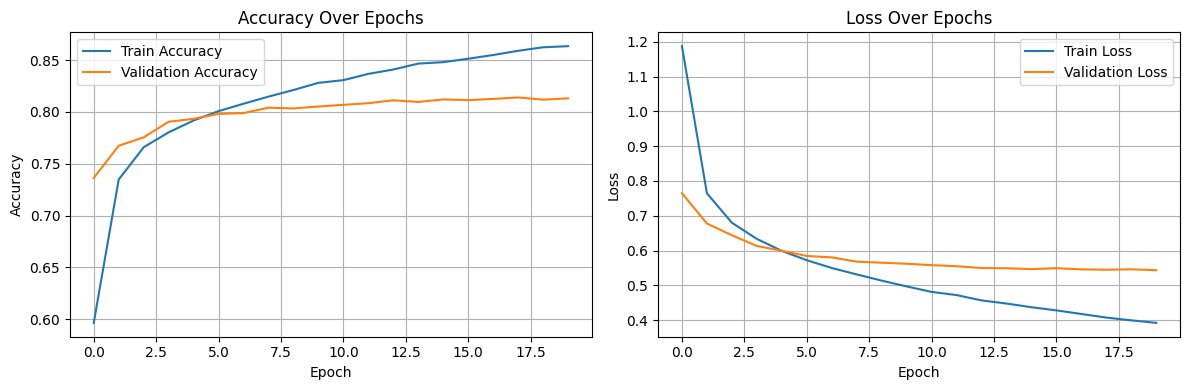

<ipython-input-22-e744b19c152f>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')


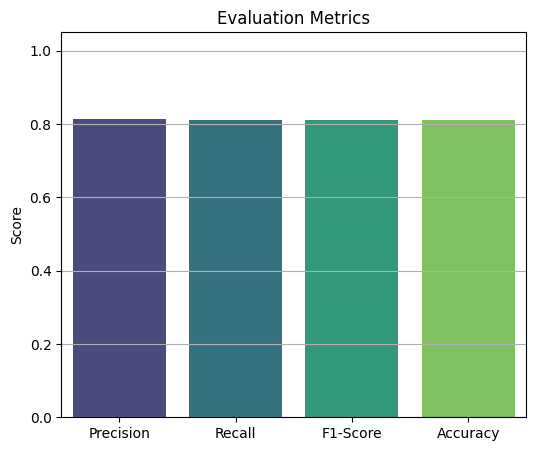

In [22]:
import matplotlib.pyplot as plt

# === 1. Accuracy Plot ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# === 2. Loss Plot ===
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === 3. Evaluation Metrics Bar Chart ===
import seaborn as sns

metrics = {
    'Precision': result['precision'],
    'Recall': result['recall'],
    'F1-Score': result['f1_score'],
    'Accuracy': result['accuracy']
}

plt.figure(figsize=(6, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.ylim(0, 1.05)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.grid(True, axis='y')
plt.show()

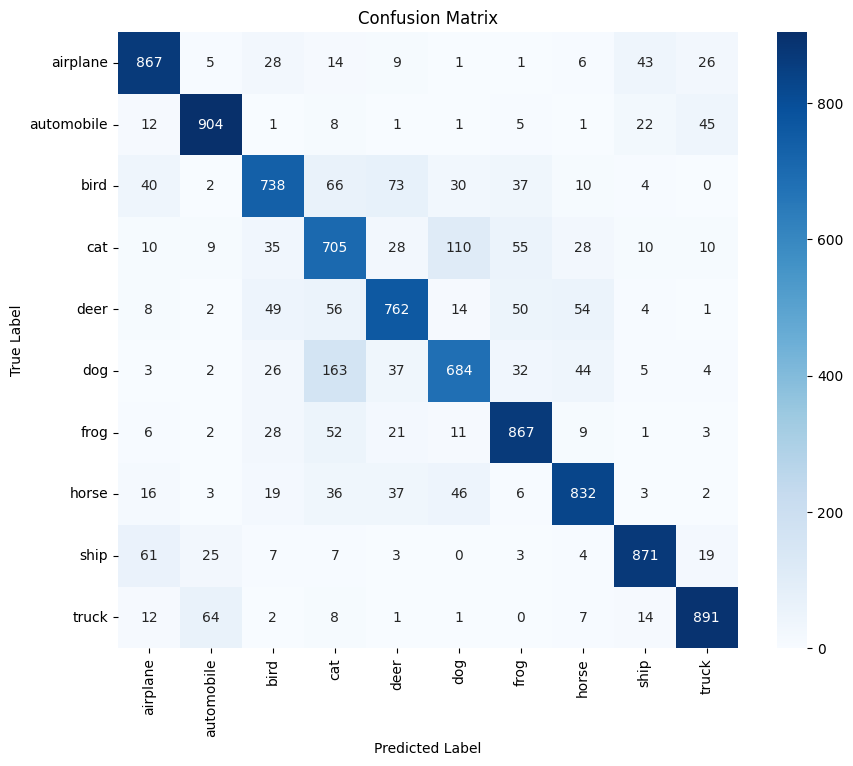

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# # Predict
# y_pred = np.argmax(model.predict(x_test_resized), axis=1)

# # Predict classes
# y_pred = np.argmax(model.predict(x_test), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### save model as .h5 and .tflite versions

In [24]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# === Load the Saved Model ===
model = load_model(os.path.join(SAVE_DIR, 'mobilenet_model.h5'))


# Save the model in .h5 format
model.save(os.path.join(SAVE_DIR, 'mobilenet_model_finetuned.h5'))



# === Convert to TFLite ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: optimize for size/speed (e.g., post-training quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# === Convert the model ===
tflite_model = converter.convert()

# === Save the TFLite model to file ===
tflite_model_path = os.path.join(SAVE_DIR, 'mobilenet_model_finetuned.tflite')
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to: {tflite_model_path}")

Saved artifact at '/tmp/tmpml4g8ekb'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137553336193808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137553336193424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137553336194384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137553336192272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137553336194000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137553336193616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137552292599312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137552292602768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137552292602384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137552292601232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13755229260392

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
!ls "/content/drive/MyDrive/Digitised work"

mobilenet_model.h5  mobilenet_model.tflite


In [28]:
!cp "/content/saved_models/mobilenet_model.h5" "/content/drive/MyDrive/Digitised work"
!cp "/content/saved_models/mobilenet_model_finetuned.tflite" "/content/drive/MyDrive/Digitised work"
!cp "/content/saved_models/mobilenet_model_finetuned.h5" "/content/drive/MyDrive/Digitised work"